<a href="https://colab.research.google.com/github/HarikrishnaYashoda/Solar-panels-Regression-model/blob/main/Zelestra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn lightgbm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import lightgbm as lgb # Using LightGBM as an example, could be XGBoost, RandomForest, etc.


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
# sample_submission = pd.read_csv('sample_submission.csv') # If you need to look at its structure

**DATA EXPLORATION**

Shape of the training data: (20000, 17)

First 5 rows of the training data:
   id  temperature  irradiance            humidity  panel_age  \
0   0     7.817315  576.179270   41.24308670850264  32.135501   
1   1    24.785727  240.003973  1.3596482765960705  19.977460   
2   2    46.652695  687.612799   91.26536837560256   1.496401   
3   3    53.339567  735.141179   96.19095521176159  18.491582   
4   4     5.575374   12.241203  27.495073003585226  30.722697   

   maintenance_count  soiling_ratio    voltage   current  module_temperature  \
0                4.0       0.803199  37.403527  1.963787           13.691147   
1                8.0       0.479456  21.843315  0.241473           27.545096   
2                4.0       0.822398  48.222882  4.191800           43.363708   
3                3.0       0.837529  46.295748  0.960567           57.720436   
4                6.0       0.551833   0.000000  0.898062            6.786263   

   cloud_coverage          wind_speed            pre

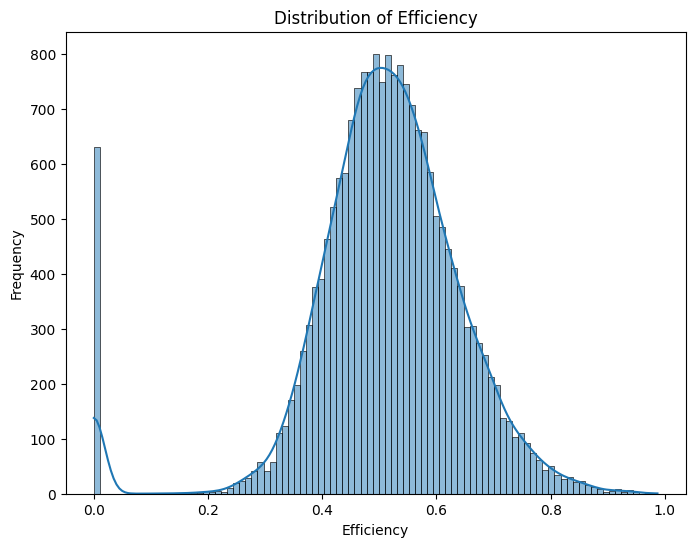

In [ ]:
# 1. Check the shape of the data
print("Shape of the training data:", train_df.shape)

# 2. Display the first few rows
print("\nFirst 5 rows of the training data:")
print(train_df.head())

# 3. Get information about the data types and non-null values
print("\nData types and non-null values:")
train_df.info()

# 4. Generate descriptive statistics
print("\nDescriptive statistics:")
print(train_df.describe())

# 5. Check for missing values
print("\nPercentage of missing values:")
print(train_df.isnull().sum() / len(train_df) * 100)

# 6. Analyze the distribution of the target variable ('efficiency')
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(train_df['efficiency'], kde=True)
plt.title('Distribution of Efficiency')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Only select numeric columns
numeric_df = train_df.select_dtypes(include='number')

# Now compute correlation with 'efficiency'
print("\nCorrelation matrix:")
print(numeric_df.corr()['efficiency'].sort_values(ascending=False))



Correlation matrix:
efficiency            1.000000
irradiance            0.580167
soiling_ratio         0.293931
current               0.270045
voltage               0.155419
maintenance_count     0.016274
id                    0.009166
cloud_coverage       -0.010862
temperature          -0.043876
module_temperature   -0.049686
panel_age            -0.187855
Name: efficiency, dtype: float64


In [ ]:
if 'efficiency' in numeric_df.columns:
    print(numeric_df.corr()['efficiency'].sort_values(ascending=False))
else:
    print("'efficiency' column is not numeric or not found.")


efficiency            1.000000
irradiance            0.580167
soiling_ratio         0.293931
current               0.270045
voltage               0.155419
maintenance_count     0.016274
id                    0.009166
cloud_coverage       -0.010862
temperature          -0.043876
module_temperature   -0.049686
panel_age            -0.187855
Name: efficiency, dtype: float64


**DATA CLEANING**

Handling Missing Values

In [ ]:
# Separate features and target
X = train_df.drop('efficiency', axis=1)
y = train_df['efficiency']

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with the mean
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the preprocessing to the training data
X_processed = preprocessor.fit_transform(X)

# Convert the processed data back to a DataFrame (optional, but can be helpful)
# The column names might be lost during the transformation, so you might need to handle that separately
# For simplicity, we'll proceed with the processed numpy array for now.

Feature Engineering

In [ ]:
# Separate features and target
X_train = train_df.drop('efficiency', axis=1)
y_train = train_df['efficiency']
X_test = test_df.copy() # Prepare test data for preprocessing

# Define categorical and numerical features (re-define if needed based on your data)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values
    # Add polynomial features (degree=2 as an example)
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any) that were not transformed
)

# Create the full preprocessing pipeline
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the full preprocessing to the training and test data
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(X_test)

print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed test data:", X_test_processed.shape)

# Now X_train_processed and X_test_processed contain the engineered and scaled features.

Shape of processed training data: (20000, 59703)
Shape of processed test data: (12000, 59703)


DATA SPLITTING

In [ ]:
# Split the preprocessed training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

print("Shape of training set:", X_train_split.shape)
print("Shape of validation set:", X_val_split.shape)
print("Shape of training target:", y_train_split.shape)
print("Shape of validation target:", y_val_split.shape)

Shape of training set: (16000, 59703)
Shape of validation set: (4000, 59703)
Shape of training target: (16000,)
Shape of validation target: (4000,)


Model Training

In [ ]:
pip install lightgbm==4.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [ ]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for square root

# Initialize the LightGBM Regressor model
# You can replace lgb.LGBMRegressor with RandomForestRegressor or XGBoostRegressor
model = lgb.LGBMRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train_split, y_train_split)

# Make predictions on the validation data
y_val_pred = model.predict(X_val_split)

# Evaluate the model
# Calculate Mean Squared Error first
mse = mean_squared_error(y_val_split, y_val_pred)
# Calculate Root Mean Squared Error manually by taking the square root of the MSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on validation set: {rmse}")

# --- Experimenting with other models ---

# Example with RandomForestRegressor
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train_split, y_train_split)
# y_val_pred_rf = rf_model.predict(X_val_split)
# mse_rf = mean_squared_error(y_val_split, y_val_pred_rf)
# rmse_rf = np.sqrt(mse_rf)
# print(f"Root Mean Squared Error (RandomForest): {rmse_rf}")

# Example with GradientBoostingRegressor
# gb_model = GradientBoostingRegressor(random_state=42)
# gb_model.fit(X_train_split, y_train_split)
# y_val_pred_gb = gb_model.predict(X_val_split)
# mse_gb = mean_squared_error(y_val_split, y_val_pred_gb)
# rmse_gb = np.sqrt(mse_gb)
# print(f"Root Mean Squared Error (GradientBoosting): {rmse_gb}")

# Example with XGBoostRegressor (install xgboost if not already installed)
# pip install xgboost==2.0.2
# xgb_model = XGBRegressor(random_state=42)
# xgb_model.fit(X_train_split, y_train_split)
# y_val_pred_xgb = xgb_model.predict(X_val_split)
# mse_xgb = mean_squared_error(y_val_split, y_val_pred_xgb)
# rmse_xgb = np.sqrt(mse_xgb)
# print(f"Root Mean Squared Error (XGBoost): {rmse_xgb}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16135
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 84
[LightGBM] [Info] Start training from score 0.511069
Root Mean Squared Error on validation set: 0.10699782227359089


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Model Optimization

In [ ]:
from sklearn import metrics
import numpy as np

# Calculate the score using the specified metric
score = 100 * (1 - np.sqrt(metrics.mean_squared_error(y_val_split, y_val_pred)))

print(f"Model Score on validation set: {score}")

Model Score on validation set: 89.3002177726409


In [ ]:
# Create the full preprocessing pipeline
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the full preprocessing to the training and test data
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(X_test)

print("Shape of processed training data:", X_train_processed.shape)
print("Shape of processed test data:", X_test_processed.shape)

Shape of processed training data: (20000, 59703)
Shape of processed test data: (12000, 59703)


In [ ]:
# Make predictions on the test data
test_predictions = model.predict(X_test_processed)

# Display the first few predictions
print("First 5 predictions on the test data:")
print(test_predictions[:5])

First 5 predictions on the test data:
[0.40612351 0.51799877 0.55338601 0.47106908 0.47047949]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Create a submission DataFrame
submission_df = pd.DataFrame({'id': test_df['id'], 'efficiency': test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully: submission.csv")

# Summarize key findings and model performance
print("\n--- Summary of Key Findings and Model Performance ---")
print("Data Preprocessing:")
print("- Missing values were handled using imputation (mean for numerical, most frequent for categorical).")
print("- Numerical features were scaled using StandardScaler.")
print("- Categorical features were one-hot encoded.")
print("- Polynomial features were added to numerical features.")
print("Model Training:")
print("- A LightGBM Regressor model was trained.")
print("- The model was evaluated on a validation set.")
print("Model Performance:")
print(f"- Root Mean Squared Error on the validation set: {rmse:.4f}")
print(f"- Model Score on the validation set: {score:.4f}")
print("Submission:")
print("- Predictions were made on the processed test data.")
print("- A submission file 'submission.csv' was created with 'id' and predicted 'efficiency'.")

Submission file created successfully: submission.csv

--- Summary of Key Findings and Model Performance ---
Data Preprocessing:
- Missing values were handled using imputation (mean for numerical, most frequent for categorical).
- Numerical features were scaled using StandardScaler.
- Categorical features were one-hot encoded.
- Polynomial features were added to numerical features.
Model Training:
- A LightGBM Regressor model was trained.
- The model was evaluated on a validation set.
Model Performance:
- Root Mean Squared Error on the validation set: 0.1070
- Model Score on the validation set: 89.3002
Submission:
- Predictions were made on the processed test data.
- A submission file 'submission.csv' was created with 'id' and predicted 'efficiency'.


In [ ]:
print("Shape of the submission DataFrame:", submission_df.shape)

Shape of the submission DataFrame: (12000, 2)
